In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.integrate import trapezoid
import numpy as np

from sim_utils import *
from clip import *
import matplotlib.pylab as plt

/home/frans/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def vmapped_sim_fn(sim_fn, params):
    # print(jax.tree_map(lambda x: x.shape if hasattr(x, 'shape') else None, params))
    if params['L'].ndim == 1:
        return jax.vmap(sim_fn, in_axes=0, out_axes=0)(params)
    else:
        return jax.vmap(partial(vmapped_sim_fn, sim_fn), in_axes=0, out_axes=0)(params)

In [3]:
def sim_worms_orig(nworms, batch_size, n_frames):
    duration = 2
    snapshots = 10
    kpoints = 32
    box_size = 64
    with numpyro.plate('batch', batch_size, dim=-2):
        with numpyro.plate('nworms', nworms, dim=-1):
            L = numpyro.sample('L', dist.Uniform(23, 28))
            # L = numpyro.sample('L', dist.Uniform(10, 15))
            A = numpyro.sample('A', dist.Normal(1, 0.1))
            T = numpyro.sample('T', dist.Normal(0.8, 0.1))
            kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi))
            ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1))
            
            inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi))
            dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8))
            phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi))
            phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi))
            phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1))
            alpha = numpyro.sample('alpha', dist.Normal(4, 4))

            alpha = jnp.abs(alpha + 1.0)
            half_box = box_size // 2
            x0 = numpyro.sample('x0', dist.Uniform(-1, 1))
            y0 = numpyro.sample('y0', dist.Uniform(-1, 1))
            x0 = x0 * half_box
            y0 = y0 * half_box

            params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}

            numpyro.deterministic("params", params)
            
            sim_fn = partial(
                worm_simulation,
                duration=duration,
                snapshots=snapshots,
                kpoints=kpoints,
            )

            with numpyro.plate('n_frames', n_frames):
                worms = vmapped_sim_fn(sim_fn, params)
                worms = worms + half_box
                # subtract mean and divide by standard deviation
                # worms = (worms - jnp.mean(worms, axis=(-5), keepdims=True)) / jnp.std(worms, axis=(-5), keepdims=True)
                numpyro.deterministic('worms', worms)
    return worms, params

In [4]:
key, nworms, box_size = random.PRNGKey(0), 2, 64

2024-08-05 16:46:50.980703: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
# seed and trace
key, nworms, box_size = random.PRNGKey(0), 2, 64


seeded_model = seed(sim_worms_orig, key)
tr = trace(seeded_model).get_trace(nworms, 40_000, 10)

In [6]:
tr["params"]["value"]["L"].shape

(40000, 2)

In [7]:
tr['worms']['value'].shape

(40000, 2, 10, 32, 2)

In [8]:
worms = tr['worms']['value'].transpose(0, 2, 1, 3, 4)
clips = jax.vmap(convert_to_clip, in_axes=(0, None))(worms, box_size)

2024-08-05 16:46:58.555756: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 5.09GiB (5469342948 bytes) by rematerialization; only reduced to 6.14GiB (6596800080 bytes), down from 6.14GiB (6596800080 bytes) originally


In [10]:
# save as npy
np.save('worms_train_40k.npy', clips)


In [ ]:

import pickle
# save tr["params"]["value"]

with open("params_40k.pkl", 'wb') as f:
    pickle.dump(tr["params"]["value"], f)

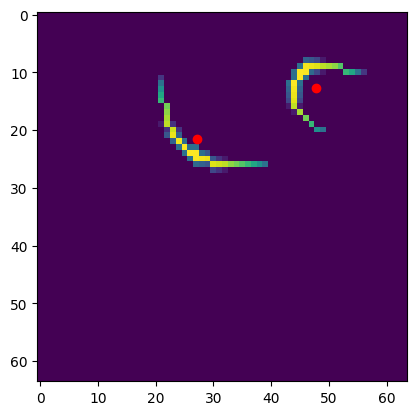

In [40]:
i = 1
frame = 9
plt.imshow(clips[i][frame])
# plot points at means
# plt.scatter(tr['x0']['value'], tr['y0']['value'])
plt.scatter(worms.mean(axis=-2)[i, frame, ..., 0], worms.mean(axis=-2)[i, frame, ..., 1], c='r')
# plt.scatter(tr['worm']['value'].mean(axis=-2)[0, ..., 0], tr['worm']['value'].mean(axis=-2)[0, ..., 1], c='r')